<a href="https://colab.research.google.com/github/SammyGbabs/FaunaPulse-Capstone-Project/blob/main/Experimentation_of_Dataset_with_Optimal_k%3D3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: mount drive for me

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


['filename', 'rms', 'spectral_entropy', 'bioacoustic_index', 'ndsi', 'event_density', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13']


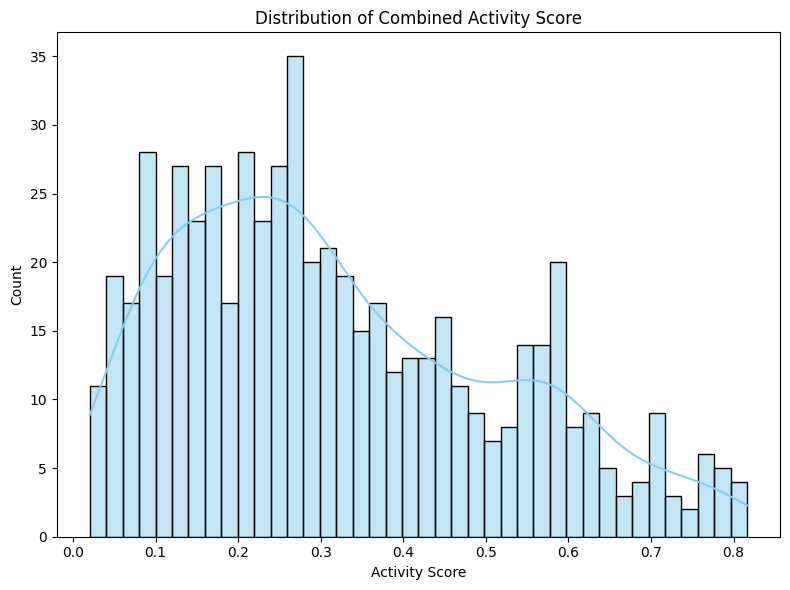

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the features CSV
df = pd.read_csv('/content/drive/MyDrive/Freq_shifted/data/features_extended.csv')

# Verify the required columns are present
print(df.columns.tolist())

# Normalize BI and Event Density
df['bi_norm'] = (df['bioacoustic_index'] - df['bioacoustic_index'].min()) / (df['bioacoustic_index'].max() - df['bioacoustic_index'].min())
df['event_density_norm'] = (df['event_density'] - df['event_density'].min()) / (df['event_density'].max() - df['event_density'].min())

# Compute the combined activity score
df['activity_score'] = (df['bi_norm'] + df['event_density_norm']) / 2

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(df['activity_score'], bins=40, kde=True, color='skyblue')
plt.title('Distribution of Combined Activity Score')
plt.xlabel('Activity Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Low Threshold (25th percentile): 0.2036
High Threshold (75th percentile): 0.3809


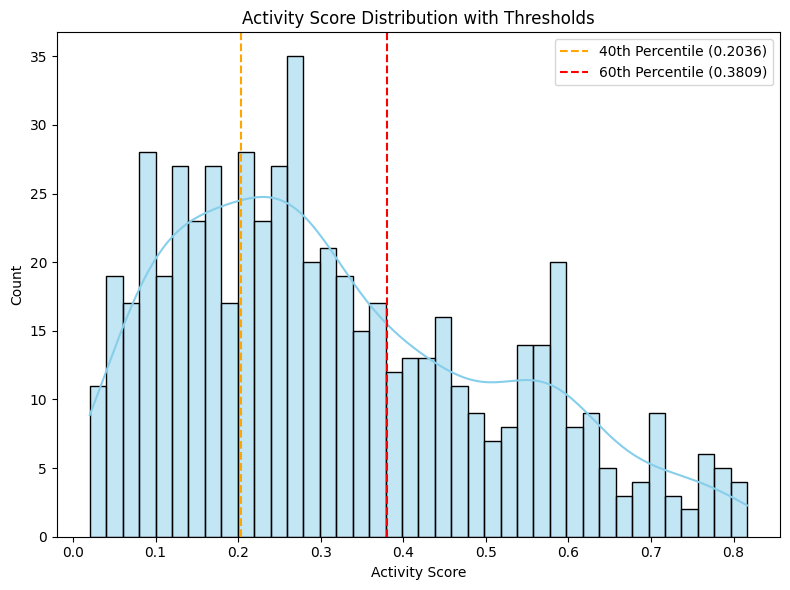

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the 25th and 75th percentile thresholds
low_threshold = df['activity_score'].quantile(0.33)
high_threshold = df['activity_score'].quantile(0.67)

print(f"Low Threshold (25th percentile): {low_threshold:.4f}")
print(f"High Threshold (75th percentile): {high_threshold:.4f}")

# Visualize the thresholds on the distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['activity_score'], bins=40, kde=True, color='skyblue')
plt.axvline(low_threshold, color='orange', linestyle='--', label=f'40th Percentile ({low_threshold:.4f})')
plt.axvline(high_threshold, color='red', linestyle='--', label=f'60th Percentile ({high_threshold:.4f})')
plt.title('Activity Score Distribution with Thresholds')
plt.xlabel('Activity Score')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# Assign Activity Labels: Low, Medium, High
def assign_label(x):
    if x <= low_threshold:
        return 'Low'
    elif x >= high_threshold:
        return 'High'
    else:
        return 'Medium'

df['activity_label'] = df['activity_score'].apply(assign_label)

# Save the labeled data
output_path = '/content/drive/MyDrive/Freq_shifted/data/labeled_features-Optimal3.csv'
df.to_csv(output_path, index=False)

# try:
#     from google.colab import files
#     files.download(output_path)
#     print(f"'{output_path}' downloaded successfully.")
# except FileNotFoundError:
#     print(f"Error: The file '{output_path}' was not found.")
# except Exception as e:
#     print(f"An error occurred during download: {e}")


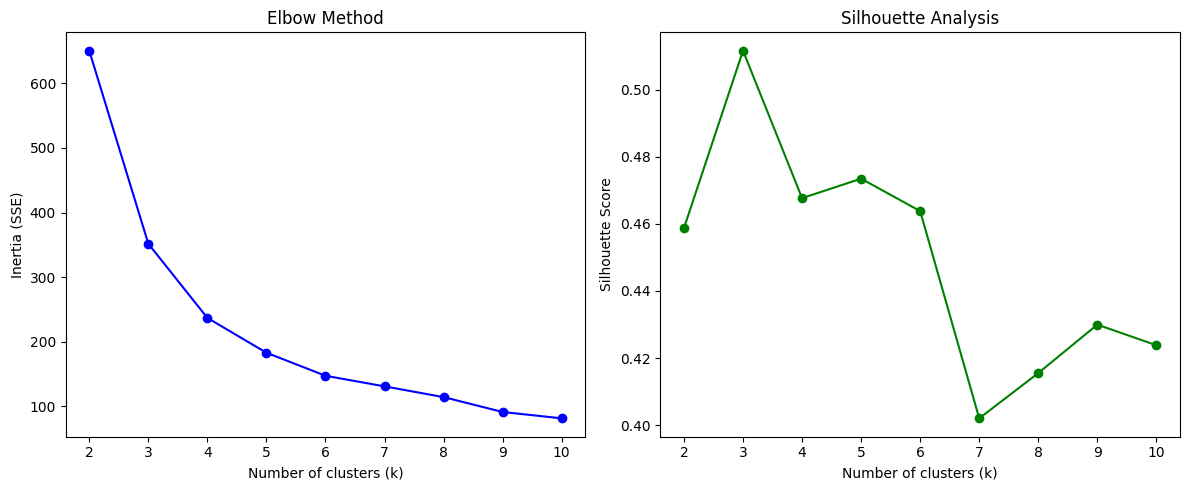

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Load the labeled dataset
labeled_features = pd.read_csv('/content/drive/MyDrive/Freq_shifted/data/labeled_features-Optimal3.csv')

# Select the core features to cluster on
features = ['bioacoustic_index', 'event_density']
X = labeled_features[features].values

# Standardize
scaler = StandardScaler().fit(X)
X_std = scaler.transform(X)

inertia = []
sil_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_std)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_std, kmeans.labels_))

# Plot Elbow
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (SSE)')
plt.title('Elbow Method')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(K_range, sil_scores, 'go-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')

plt.tight_layout()
plt.show()



In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_std)
labeled_features[['tsne_1', 'tsne_2']] = X_tsne

k_opt = 3  # Replace this with your chosen k
kmeans = KMeans(n_clusters=k_opt, random_state=42)
labeled_features['cluster'] = kmeans.fit_predict(X_tsne)

cluster_means = labeled_features.groupby('cluster')['activity_score'].mean().sort_values()
cluster_map = {cluster: label for cluster, label in zip(cluster_means.index, ['Low', 'Medium', 'High'])}
labeled_features['cluster_label'] = labeled_features['cluster'].map(cluster_map)

Adjusted Rand Index between threshold and clustering labels: 0.477
Confusion Matrix (cluster vs threshold):
[[184  10   0]
 [ 15 139  46]
 [  0  71 123]]

Classification Report (cluster vs threshold):
              precision    recall  f1-score   support

         Low       0.92      0.95      0.94       194
      Medium       0.63      0.69      0.66       200
        High       0.73      0.63      0.68       194

    accuracy                           0.76       588
   macro avg       0.76      0.76      0.76       588
weighted avg       0.76      0.76      0.76       588



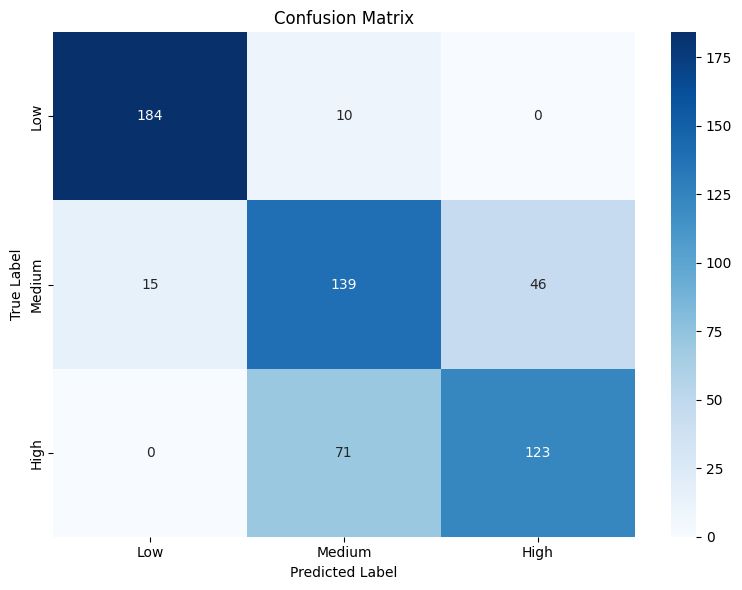

In [ ]:
from sklearn.metrics import adjusted_rand_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Map activity and cluster labels to numeric values for comparison
label_map = {'Low': 0, 'Medium': 1, 'High': 2}
y_true = labeled_features['activity_label'].map(label_map)
y_pred = labeled_features['cluster_label'].map(label_map)

# Compute Adjusted Rand Index
ari = adjusted_rand_score(y_true, y_pred)
print(f"Adjusted Rand Index between threshold and clustering labels: {ari:.3f}")

# Confusion Matrix and Classification Report
print("Confusion Matrix (cluster vs threshold):")
cm = confusion_matrix(y_true, y_pred)
print(cm)

print("\nClassification Report (cluster vs threshold):")
print(classification_report(y_true, y_pred, target_names=['Low', 'Medium', 'High']))

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [ ]:
import os
import shutil
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Paths
all_audio_dir = '/content/drive/MyDrive/Freq_shifted/data'
high_dir = '/content/drive/MyDrive/Freq_shifted/optimal3/high_activity'
medium_dir = '/content/drive/MyDrive/Freq_shifted/optimal3/medium_activity'
low_dir = '/content/drive/MyDrive/Freq_shifted/optimal3/low_activity'

# Create output directories if they don't exist
os.makedirs(high_dir, exist_ok=True)
os.makedirs(medium_dir, exist_ok=True)
os.makedirs(low_dir, exist_ok=True)

# Valid audio extensions
audio_exts = {'.wav', '.mp3', '.flac', '.ogg'}

# Define consensus subset (where threshold and cluster labels agree)
consensus = labeled_features[labeled_features['activity_label'] == labeled_features['cluster_label']].copy()

# Train Random Forest on consensus subset
X = consensus[['bioacoustic_index', 'event_density']]
y = consensus['activity_label'].map({'Low': 0, 'Medium': 1, 'High': 2})
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on non-consensus subset
non_consensus = labeled_features[labeled_features['activity_label'] != labeled_features['cluster_label']].copy()
X_non = non_consensus[['bioacoustic_index', 'event_density']]
preds = clf.predict(X_non)
non_consensus['predicted_label'] = pd.Series(preds).map({0: 'Low', 1: 'Medium', 2: 'High'})

# Combine final labels
consensus['final_label'] = consensus['activity_label']
non_consensus['final_label'] = non_consensus['predicted_label']
final_df = pd.concat([consensus, non_consensus], ignore_index=True)

# Move audio files into respective folders (only audio files)
for _, row in final_df.iterrows():
    fn = row['filename']
    # Only process if extension is in our audio list
    if os.path.splitext(fn)[1].lower() not in audio_exts:
        continue

    src = os.path.join(all_audio_dir, fn)
    if not os.path.isfile(src):
        continue

    # Choose directory based on final_label
    if row['final_label'] == 'High':
        dest_dir = high_dir
    elif row['final_label'] == 'Medium':
        dest_dir = medium_dir
    else:
        dest_dir = low_dir

    shutil.copy(src, os.path.join(dest_dir, fn))

# Summary of file distribution
print(f"Files moved: High = {len(final_df[final_df['final_label'] == 'High'])}, "
      f"Medium = {len(final_df[final_df['final_label'] == 'Medium'])}, "
      f"Low = {len(final_df[final_df['final_label'] == 'Low'])}")


Files moved: High = 132, Medium = 150, Low = 192


In [ ]:
# Paths (ensure these are correct after mounting your drive)
dataset_dir   = '/content/drive/MyDrive/Freq_shifted/optimal3'
final_csv     = os.path.join(dataset_dir, 'final_labels-Optimal3.csv')

# Save the final DataFrame to CSV
final_df.to_csv(final_csv, index=False)
print(f"Final labels CSV saved to: {final_csv}")
try:
  files.download(final_csv)
  print(f"'final csv' downloaded successfully.")
except FileNotFoundError:
  print(f"Error: The file '{features_csv_path}' was not found.")
except Exception as e:
  print(f"An error occurred during download: {e}")

Final labels CSV saved to: /content/drive/MyDrive/Freq_shifted/optimal3/final_labels-Optimal3.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'final csv' downloaded successfully.


In [ ]:
# Check the number of files in the high and low activity folders
print("\nChecking number of files in high_activity, medium_activity and low_activity folders:")
if os.path.isdir(os.path.join(dataset_dir, 'high_activity')):
    high_count = len([name for name in os.listdir(os.path.join(dataset_dir, 'high_activity')) if os.path.isfile(os.path.join(dataset_dir, 'high_activity', name))])
    print(f"Number of files in high_activity: {high_count}")
else:
    print("high_activity directory not found.")

if os.path.isdir(os.path.join(dataset_dir, 'medium_activity')):
    low_count = len([name for name in os.listdir(os.path.join(dataset_dir, 'medium_activity')) if os.path.isfile(os.path.join(dataset_dir, 'medium_activity', name))])
    print(f"Number of files in medium_activity: {low_count}")
else:
    print("medium_activity directory not found.")

if os.path.isdir(os.path.join(dataset_dir, 'low_activity')):
    low_count = len([name for name in os.listdir(os.path.join(dataset_dir, 'low_activity')) if os.path.isfile(os.path.join(dataset_dir, 'low_activity', name))])
    print(f"Number of files in low_activity: {low_count}")
else:
    print("low_activity directory not found.")


Checking number of files in high_activity, medium_activity and low_activity folders:
Number of files in high_activity: 132
Number of files in medium_activity: 150
Number of files in low_activity: 306
